In [56]:

from pathlib import Path

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

import seaborn as sns
import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score


In [57]:
df = pd.read_csv('https://raw.githubusercontent.com/57662584/MMAI5000_group_14_project/refs/heads/main/Data-ATP-W119-PEW.csv')
print(df.head())
df.columns = [col[:-5] + '_W119' if col.lower().endswith('_w119') else col for col in df.columns]



ERROR! Session/line number was not unique in database. History logging moved to new session 151
     QKEY INTERVIEW_START_W119   INTERVIEW_END_W119  DEVICE_TYPE_W119  \
0  100314  12/13/2022 23:12:27  12/13/2022 23:23:59                 2   
1  100363  12/13/2022 19:50:59  12/13/2022 20:05:29                 2   
2  100598  12/14/2022 16:30:21  12/14/2022 16:47:21                 1   
3  100637  12/14/2022 08:22:09  12/14/2022 08:33:45                 1   
4  100803  12/15/2022 09:05:46  12/15/2022 09:22:29                 1   

   LANG_W119  FORM_W119  DESRISK_COMF_W119  DESRISK_CREAT_W119  \
0          1          1                  4                   3   
1          1          2                  3                   3   
2          1          1                  4                   4   
3          1          2                  2                   1   
4          1          2                  3                   3   

   DESRISK_NTECH_W119  RISK2_W119  ...  F_PARTYLN_FINAL  F_PARTYSUM_

C:\Users\User\AppData\Local\Temp\ipykernel_14448\2529272665.py:1: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('https://raw.githubusercontent.com/57662584/MMAI5000_group_14_project/refs/heads/main/Data-ATP-W119-PEW.csv')


In [58]:
def plot_vars(df, max_cat_unique=20, bins=20, cols=5, figsize=(20, 4)):
    """
    Display a bar or histogram of all variables in a DataFrame on the same canvas.


    ----
    df : pandas.DataFrame
    max_cat_unique : int, if the number of uniques is less than or equal to this value, draw bars according to the categorical variable
    bins : int, the number of bins for the histogram
    cols : int, the number of sub-figures displayed per row
    figsize : tuple, the canvas size of each row of sub-figures
    """
    n = len(df.columns)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        if pd.api.types.is_numeric_dtype(df[col]):
            sns.histplot(df[col].dropna(), bins=bins, kde=False, ax=ax)
            ax.set_title(f'Hist of {col}')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')
        else:
            n_unique = df[col].nunique(dropna=True)
            if n_unique <= max_cat_unique:
                sns.countplot(x=col, data=df, ax=ax)
                ax.set_title(f'Bar of {col}')
                ax.set_xlabel(col)
                ax.set_ylabel('Count')
                ax.tick_params(axis='x', rotation=30)
            else:
                ax.set_visible(False)  
                print(f"{col} 变量unique值太多（{n_unique}），跳过")
  
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [59]:
# Extract the specified variables
variables_to_extract = [
    'DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119', 'RISK2_W119',
    'AI_HEARD_W119', 'CNCEXC_W119', 'USEAI_W119',
    'AIKNOW1_W119', 'AIKNOW2_W119', 'AIKNOW3_W119', 'AIKNOW5_W119', 'AIKNOW6_W119', 'AIKNOW7_W119',
    'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 
    'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119', 'AIKNOW_INDEX_W119',
    'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119', 'MEDBIAS_W119',
    'AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119', 'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119',
    'HCMEDBIAS_W119', 'EMPLSIT_W119', 'JOBAPPYR_W119', 'INDUSTRYCOMBO_W119',
    'AIWRK2_a_W119', 'AIWRK2_b_W119', 'AIWRK2_c_W119',
    'AIWRK3_a_W119', 'AIWRK3_b_W119', 'AIWRK3_c_W119',
    'AIWRKH1_W119', 'AIWRKH2_a_W119', 'AIWRKH2_b_W119',
    'AIWRKH3_a_W119', 'AIWRKH3_b_W119', 'AIWRKH3_c_W119', 'AIWRKH3_d_W119', 'AIWRKH4_W119',
    'AIWRKM1_W119', 'AIWRKM2_a_W119', 'AIWRKM2_b_W119', 'AIWRKM2_c_W119', 'AIWRKM2_d_W119',
    'AIWRKM2_e_W119', 'AIWRKM2_f_W119', 'AIWRKM3_a_W119', 'AIWRKM3_b_W119', 'AIWRKM3_c_W119',
    'AIWRKM3_d_W119', 'AIWRKM3_e_W119', 'AIWRKM3_f_W119', 'AIWRKM4_a_W119', 'AIWRKM4_b_W119',
    'F_AGECAT', 'F_GENDER', 'F_EDUCCAT', 'F_EDUCCAT2', 'F_RACECMB', 'F_RACETHNMOD',
    'F_CITIZEN', 'F_BIRTHPLACE', 'F_HISP', 'F_HISP_ORIGIN', 'F_CREGION', 'F_CDIVISION',
    'F_METRO', 'F_REG', 'F_INC_SDT1', 'F_INC_TIER2', 'F_MARITAL', 'F_RELIG',
    'F_RELIGCAT1', 'F_ATTEND', 'F_PARTY_FINAL', 'F_PARTYLN_FINAL', 'F_PARTYSUM_FINAL',
    'F_PARTYSUMIDEO_FINAL', 'F_IDEO'
]

# Check which variables exist in the dataset
available_vars = [var for var in variables_to_extract if var in df.columns]
missing_vars = [var for var in variables_to_extract if var not in df.columns]

print(f"Available variables: {len(available_vars)}")
print(f"Missing variables: {len(missing_vars)}")

if missing_vars:
    print(f"\nMissing variables: {missing_vars}")

# Extract the available variables
df_selected = df[available_vars].copy()

print(f"\nDataset shape after extraction: {df_selected.shape}")
print(f"Selected variables: {list(df_selected.columns)}")

# Display basic info about the extracted dataset
print(f"\nBasic info:")
print(df_selected.info())

Available variables: 87
Missing variables: 0

Dataset shape after extraction: (11004, 87)
Selected variables: ['DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119', 'RISK2_W119', 'AI_HEARD_W119', 'CNCEXC_W119', 'USEAI_W119', 'AIKNOW1_W119', 'AIKNOW2_W119', 'AIKNOW3_W119', 'AIKNOW5_W119', 'AIKNOW6_W119', 'AIKNOW7_W119', 'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119', 'AIKNOW_INDEX_W119', 'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119', 'MEDBIAS_W119', 'AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119', 'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119', 'HCMEDBIAS_W119', 'EMPLSIT_W119', 'JOBAPPYR_W119', 'INDUSTRYCOMBO_W119', 'AIWRK2_a_W119', 'AIWRK2_b_W119', 'AIWRK2_c_W119', 'AIWRK3_a_W119', 'AIWRK3_b_W119', 'AIWRK3_c_W119', 'AIWRKH1_W119', 'AIWRKH2_a_W119', 'AIWRKH2_b_W119', 'AIWRKH3_a_W119', 'AIWRKH3_b_W119', 'AIWRKH3_c_W119', 'AIWRKH3_d_W119', 'AIWRKH4_W119', 'AIWRKM1_W119

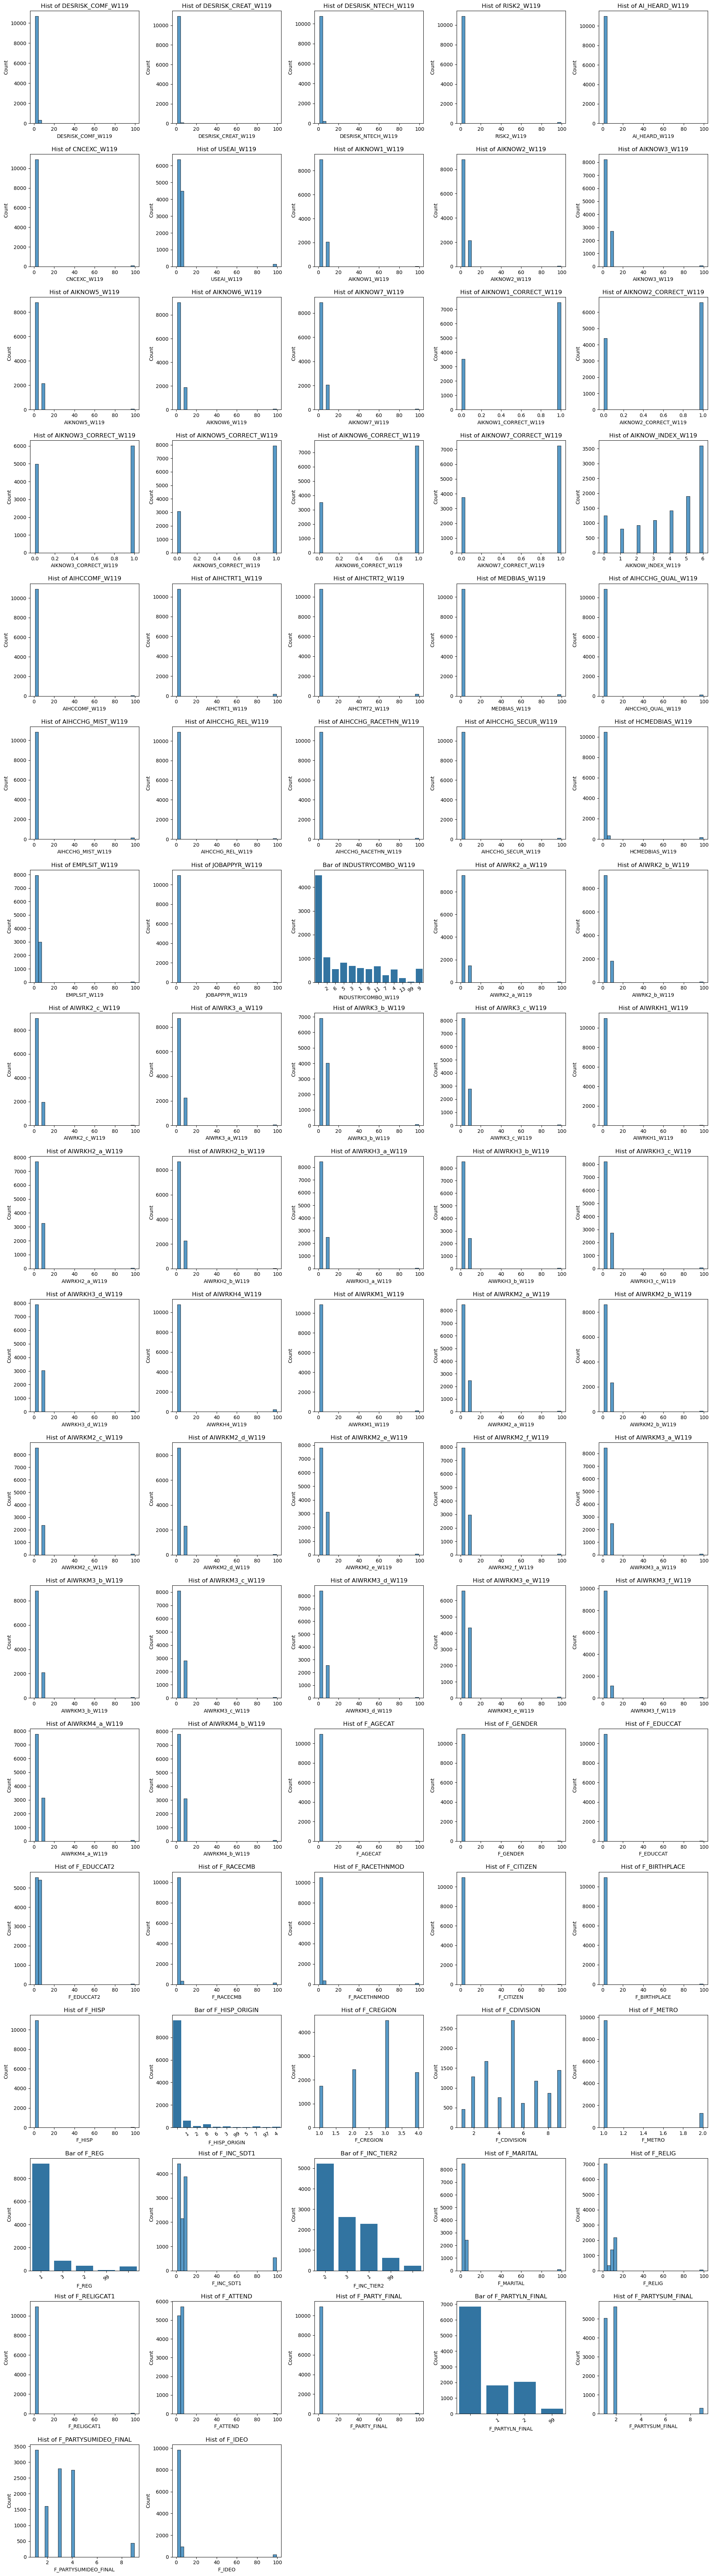

In [60]:
# View the distribution of all variables
import matplotlib.pyplot as plt
plot_vars(df_selected, max_cat_unique=20, bins=30, cols=5, figsize=(20, 4))


In [61]:
# Export descriptive statistics of numeric variables to CSV
num_cols = df_selected.select_dtypes(include=['number']).columns
num_stats = df_selected[num_cols].describe().transpose()
# num_stats.to_csv('numerical_variable_distribution.csv', index=True)
print("Numerical variable distribution saved to 'numerical_variable_distribution.csv'.")

# Export frequency statistics of categorical variables to CSV
cat_cols = df_selected.select_dtypes(include=['object', 'category']).columns
cat_stats_list = []
for col in cat_cols:
    value_counts = df_selected[col].value_counts(dropna=False)
    temp_df = value_counts.reset_index()
    temp_df.columns = ['value', 'count']
    temp_df['variable'] = col
    cat_stats_list.append(temp_df)
cat_stats_df = pd.concat(cat_stats_list, ignore_index=True)[['variable', 'value', 'count']]
# cat_stats_df.to_csv('categorical_variable_distribution.csv', index=False)
print("Categorical variable distribution saved to 'categorical_variable_distribution.csv'.")

Numerical variable distribution saved to 'numerical_variable_distribution.csv'.
Categorical variable distribution saved to 'categorical_variable_distribution.csv'.


Missing values after cleaning:
F_HISP_ORIGIN         9594
F_PARTYLN_FINAL       7157
INDUSTRYCOMBO_W119    4525
F_INC_TIER2            863
F_INC_SDT1             542
                      ... 
F_CITIZEN               13
DESRISK_NTECH_W119       8
AI_HEARD_W119            8
DESRISK_COMF_W119        7
DESRISK_CREAT_W119       6
Length: 75, dtype: int64

Missing value percentages:
F_HISP_ORIGIN         87.186478
F_PARTYLN_FINAL       65.039985
INDUSTRYCOMBO_W119    41.121410
F_INC_TIER2            7.842603
F_INC_SDT1             4.925482
                        ...    
F_CITIZEN              0.118139
AI_HEARD_W119          0.072701
DESRISK_NTECH_W119     0.072701
DESRISK_COMF_W119      0.063613
DESRISK_CREAT_W119     0.054526
Length: 75, dtype: float64

Dataset info after cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  

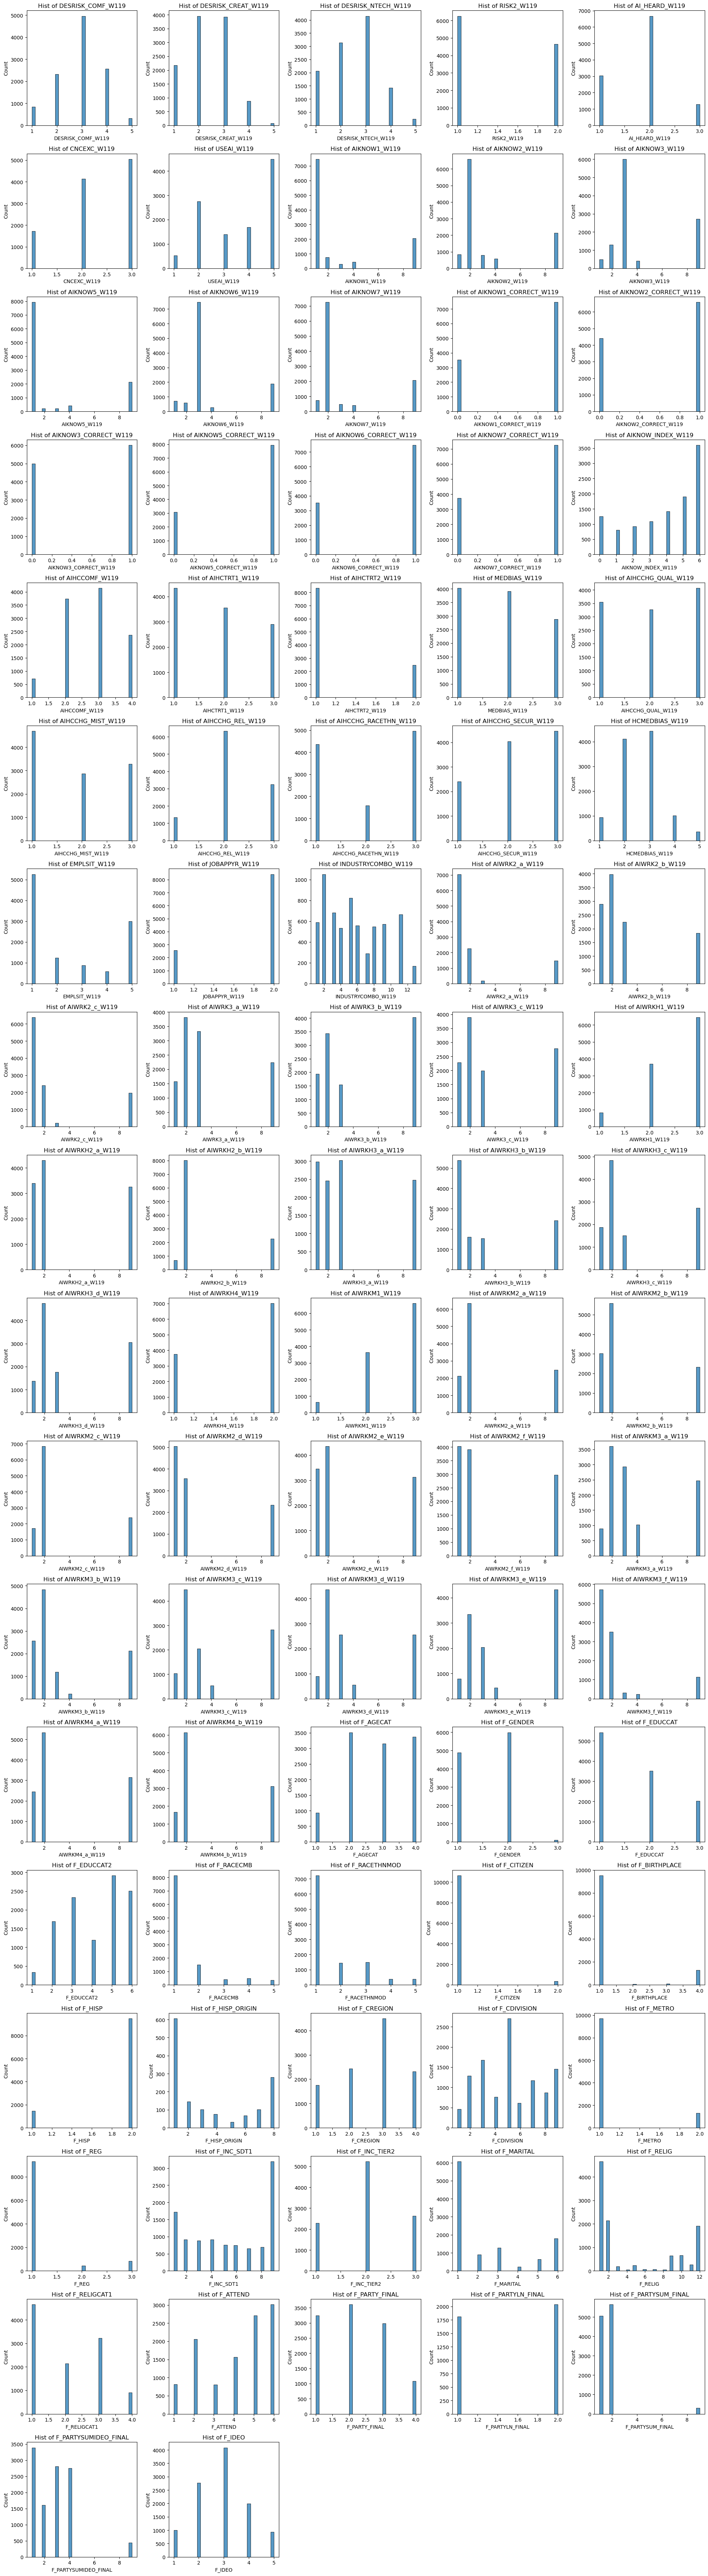

Original data shape: (11004, 87)
Cleaned data shape: (11004, 87)
Total missing values removed: 6376


In [62]:
# Dealing with missing value encoding

df_cleaned = df_selected.copy()
for col in df_cleaned.columns:
    df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')

# Define the value that needs to be replaced with NaN
missing_codes = [97, 98, 99]

for col in df_cleaned.columns:
    df_cleaned[col] = df_cleaned[col].replace(missing_codes, np.nan)


print("Missing values after cleaning:")
missing_summary = df_cleaned.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)


missing_percentage = (df_cleaned.isnull().sum() / len(df_cleaned) * 100).sort_values(ascending=False)
missing_percentage = missing_percentage[missing_percentage > 0]
print(f"\nMissing value percentages:")
print(missing_percentage)


print(f"\nDataset info after cleaning:")
print(df_cleaned.info())

plot_vars(df_cleaned, max_cat_unique=20, bins=30, cols=5, figsize=(20, 4))

print(f"Original data shape: {df_selected.shape}")
print(f"Cleaned data shape: {df_cleaned.shape}")
print(f"Total missing values removed: {(df_selected == 99).sum().sum() + (df_selected == 98).sum().sum() + (df_selected == 97).sum().sum()}")

Likert scale variables have been recoded to ordinal numeric values.

Recoding summary:
- Attitude variables (reversed): ['DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119', 'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119']
- Binary variables (1=Yes, 0=No): ['AI_HEARD_W119', 'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119']
- Change variables (reversed): ['AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119', 'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119']

Dataset info after recoding:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11004 entries, 0 to 11003
Data columns (total 87 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DESRISK_COMF_W119     10997 non-null  float64
 1   DESRISK_CREAT_W119    10998 non-null  float64
 2   DESRISK_NTECH_W119    10996 non-null  float64
 3   RISK2_W119            10896 

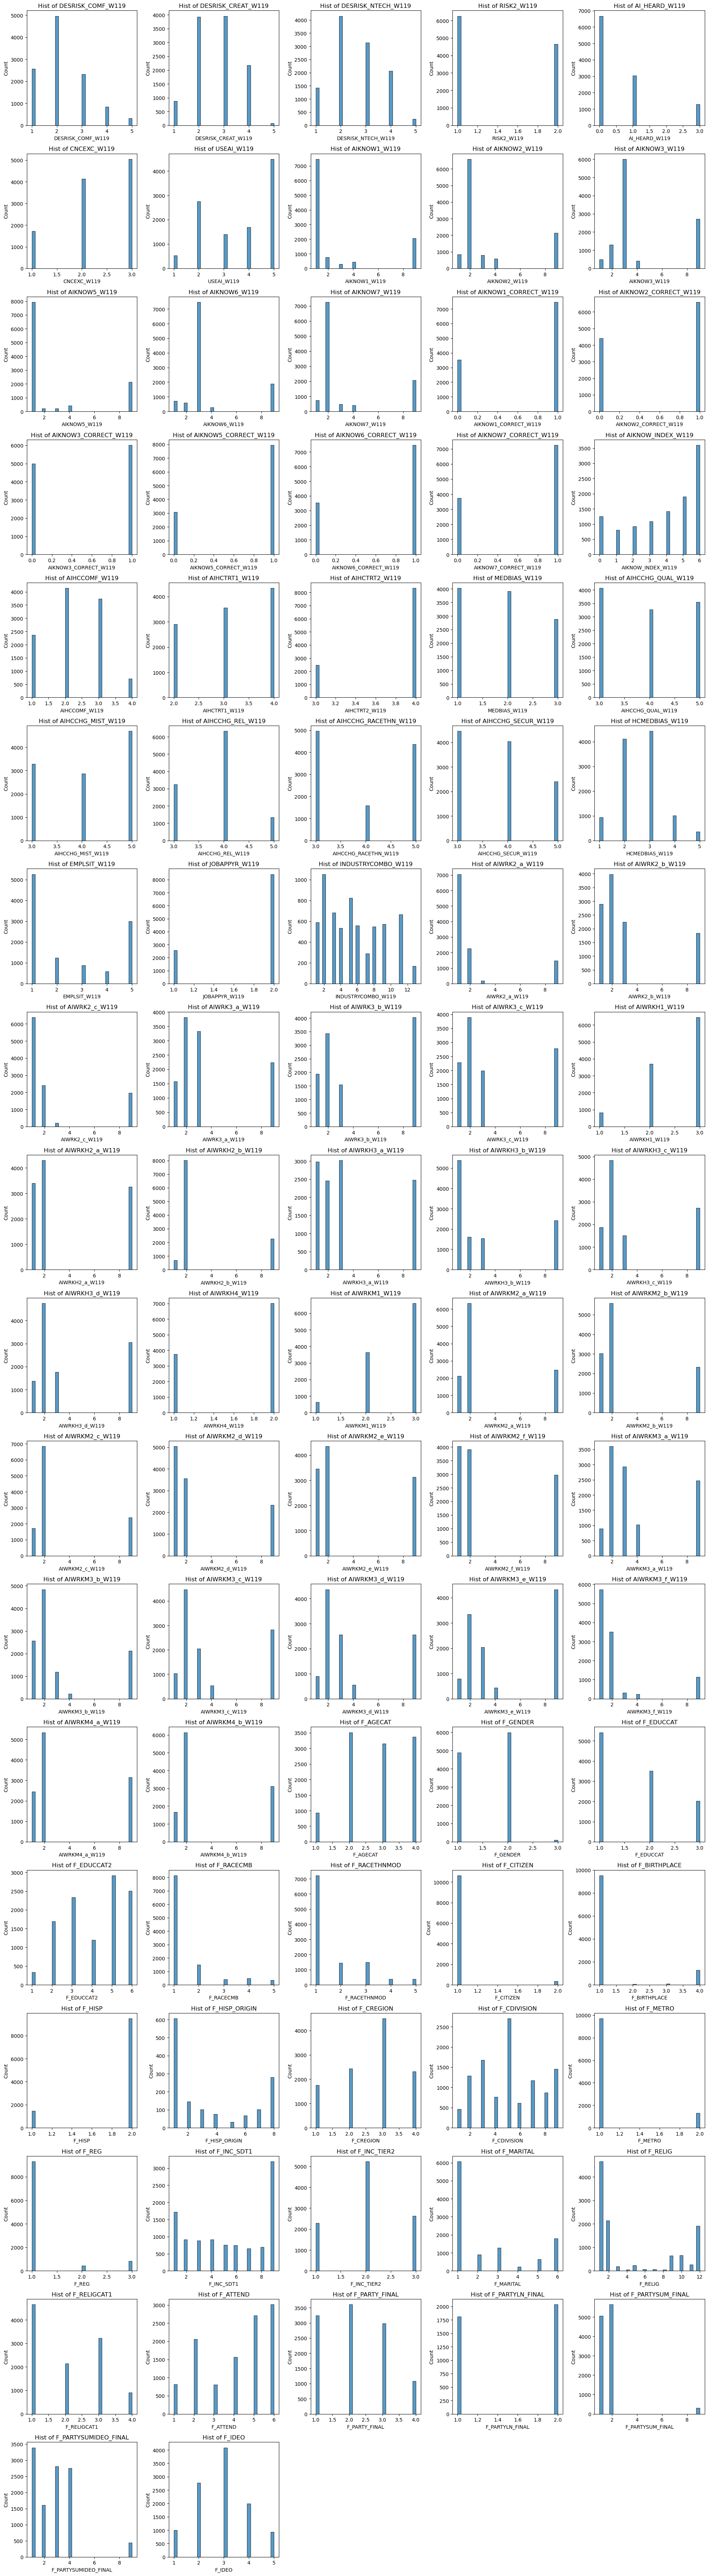


Sample distributions after recoding:


In [63]:
# Recode Likert scale responses to ordinal values
import numpy as np

# 创建重编码后的数据副本
df_recoded = df_cleaned.copy()

# Recode according to common encoding methods of PEW data

# For attitude/agreement variables (usually 1=strongly agree, 2=somewhat agree, 3=somewhat disagree, 4=strongly disagree)
# Recoded to 4=strongly agree, 3=somewhat agree, 2=somewhat disagree, 1=strongly disagree

attitude_vars = [
    'DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119',
    'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119'
]

for var in attitude_vars:
    if var in df_recoded.columns:

        df_recoded[var] = df_recoded[var].replace({1: 4, 2: 3, 3: 2, 4: 1})

# For frequency variables (1=never, 2=rarely, 3=sometimes, 4=often)
# Keep original coding or adjust as needed

frequency_vars = [
    'USEAI_W119'
]

# For yes/no variables (1=yes, 2=no)
# Recode to 1=yes, 0=no

binary_vars = [
    'AI_HEARD_W119', 'AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 
    'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 
    'AIKNOW7_CORRECT_W119'
]

for var in binary_vars:
    if var in df_recoded.columns:
        # 1=是->1, 2=否->0
        df_recoded[var] = df_recoded[var].replace({2: 0})

# For the degree of change variable (1=greatly improved, 2=somewhat improved, 3=no change, 4=somewhat worsened, 5=greatly worsened)
# Recode to 5=greatly improved, 4=somewhat improved, 3=no change, 2=somewhat worsened, 1=greatly worsened

change_vars = [
    'AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119', 
    'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119'
]

for var in change_vars:
    if var in df_recoded.columns:
        df_recoded[var] = df_recoded[var].replace({1: 5, 2: 4, 4: 2, 5: 1})

print("Likert scale variables have been recoded to ordinal numeric values.")
print("\nRecoding summary:")
print(f"- Attitude variables (reversed): {attitude_vars}")
print(f"- Binary variables (1=Yes, 0=No): {binary_vars}")
print(f"- Change variables (reversed): {change_vars}")

print(f"\nDataset info after recoding:")
print(df_recoded.info())

plot_vars(df_recoded, max_cat_unique=20, bins=30, cols=5, figsize=(20, 4))
print(f"\nSample distributions after recoding:")
# for var in attitude_vars[:3]:
#     if var in df_recoded.columns:
#         print(f"\n{var}:")
#         print(df_recoded[var].value_counts(dropna=False).sort_index())

In [64]:
# Create binary/grouping variables based on age, technology familiarity, and AI skepticism
import numpy as np

df_features = df_recoded.copy()

# Age group variable (age_group)
if 'F_AGECAT' in df_features.columns:
    # Divide the continuous value of age into three groups
    df_features['age_group'] = np.select([
        df_features['F_AGECAT'] <= 2,      # Young Group (18-39)
        df_features['F_AGECAT'].between(3, 4),  # Middle-aged group (40-64)
        df_features['F_AGECAT'] >= 5       # Seniors (65+)
    ], [1, 2, 3], default=np.nan)

    df_features['age_young'] = np.where(df_features['F_AGECAT'] <= 2, 1, 0)
    df_features['age_senior'] = np.where(df_features['F_AGECAT'] >= 5, 1, 0)

# 2. AI acceptance score (AI_acceptance_score)
# Build a composite score based on key AI-related questions
ai_acceptance_vars = []

# Add AI medical trust related variables
healthcare_trust_vars = ['AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119']
available_hc_vars = [var for var in healthcare_trust_vars if var in df_features.columns]
ai_acceptance_vars.extend(available_hc_vars)

# Add AI risk perception variable (reverse coded, higher values ​​are more acceptable)
risk_vars = ['DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119']
available_risk_vars = [var for var in risk_vars if var in df_features.columns]
ai_acceptance_vars.extend(available_risk_vars)

# Add AI usage frequency
if 'USEAI_W119' in df_features.columns:
    ai_acceptance_vars.append('USEAI_W119')

# Add AI heard situations
if 'AI_HEARD_W119' in df_features.columns:
    ai_acceptance_vars.append('AI_HEARD_W119')

# Calculating the AI ​​acceptance composite score
if ai_acceptance_vars:

    df_standardized = df_features[ai_acceptance_vars].copy()
    for var in ai_acceptance_vars:
        min_val = df_features[var].min()
        max_val = df_features[var].max()
        if max_val > min_val:
            df_standardized[var] = (df_features[var] - min_val) / (max_val - min_val)
    
    
    df_features['AI_acceptance_score'] = df_standardized.mean(axis=1)
    
    
    df_features['high_ai_acceptance'] = np.where(df_features['AI_acceptance_score'] > 0.5, 1, 0)

# Technological literacy index (tech_literacy_index)
# Based on the problem of adaptability to emerging technologies

tech_literacy_vars = []

# AI knowledge correctness variable
ai_knowledge_vars = ['AIKNOW1_CORRECT_W119', 'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 
                     'AIKNOW5_CORRECT_W119', 'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119']
available_knowledge_vars = [var for var in ai_knowledge_vars if var in df_features.columns]
tech_literacy_vars.extend(available_knowledge_vars)


if 'USEAI_W119' in df_features.columns:
    tech_literacy_vars.append('USEAI_W119')


if 'AIKNOW_INDEX_W119' in df_features.columns:
    tech_literacy_vars.append('AIKNOW_INDEX_W119')

# Computing Literacy Index
if tech_literacy_vars:

    df_tech_standardized = df_features[tech_literacy_vars].copy()
    
    for var in tech_literacy_vars:
        if var in available_knowledge_vars:
            # 
            continue
        else:
            
            min_val = df_features[var].min()
            max_val = df_features[var].max()
            if max_val > min_val:
                df_tech_standardized[var] = (df_features[var] - min_val) / (max_val - min_val)
    
  
    df_features['tech_literacy_index'] = df_tech_standardized.mean(axis=1)
    

    df_features['high_tech_literacy'] = np.where(df_features['tech_literacy_index'] > 0.5, 1, 0)

# 4. Create interaction variables
# Young high-tech users

if 'age_young' in df_features.columns and 'high_tech_literacy' in df_features.columns:
    df_features['young_tech_savvy'] = df_features['age_young'] * df_features['high_tech_literacy']

# Older users with low AI acceptance
if 'age_senior' in df_features.columns and 'high_ai_acceptance' in df_features.columns:
    df_features['senior_ai_resistant'] = df_features['age_senior'] * (1 - df_features['high_ai_acceptance'])


if 'age_group' in df_features.columns and 'AI_acceptance_score' in df_features.columns:
    # Create four groups based on age and AI acceptance
    df_features['age_ai_profile'] = np.select([
        (df_features['age_group'] <= 2) & (df_features['AI_acceptance_score'] > 0.5),  # Young + High Acceptance
        (df_features['age_group'] <= 2) & (df_features['AI_acceptance_score'] <= 0.5), # Young + Low Acceptance
        (df_features['age_group'] >= 3) & (df_features['AI_acceptance_score'] > 0.5),  # Older + Highly Acceptable
        (df_features['age_group'] >= 3) & (df_features['AI_acceptance_score'] <= 0.5)  # Older + Low Acceptance
    ], [1, 2, 3, 4], default=np.nan)

new_vars = [col for col in df_features.columns if col not in df_recoded.columns]
print("Newly created variables:")
for var in new_vars:
    print(f"- {var}")

key_vars = ['age_group', 'AI_acceptance_score', 'tech_literacy_index']
print("\nDistribution of key variables:")
for var in key_vars:
    if var in df_features.columns:
        print(f"\n{var}:")
        if var == 'age_group':
            print(df_features[var].value_counts(dropna=False).sort_index())
        else:
            print(df_features[var].describe())


binary_vars = ['high_ai_acceptance', 'high_tech_literacy', 'young_tech_savvy', 'senior_ai_resistant']
print("\nDistribution of binary variables:")
for var in binary_vars:
    if var in df_features.columns:
        print(f"\n{var}:")
        print(df_features[var].value_counts(dropna=False))


print(f"\nDataset shape before feature engineering: {df_recoded.shape}")
print(f"Dataset shape after feature engineering: {df_features.shape}")
print(f"Number of new variables created: {len(new_vars)}")


print(f"\nFinal dataset ready for analysis with {df_features.shape[1]} variables and {df_features.shape[0]} observations.")

Newly created variables:
- age_group
- age_young
- age_senior
- AI_acceptance_score
- high_ai_acceptance
- tech_literacy_index
- high_tech_literacy
- young_tech_savvy
- senior_ai_resistant
- age_ai_profile

Distribution of key variables:

age_group:
age_group
1.0    4444
2.0    6524
NaN      36
Name: count, dtype: int64

AI_acceptance_score:
count    11004.000000
mean         0.467192
std          0.109726
min          0.050000
25%          0.395833
50%          0.467708
75%          0.541667
max          0.906250
Name: AI_acceptance_score, dtype: float64

tech_literacy_index:
count    11004.000000
mean         0.648269
std          0.294663
min          0.000000
25%          0.416667
50%          0.729167
75%          0.906250
max          1.000000
Name: tech_literacy_index, dtype: float64

Distribution of binary variables:

high_ai_acceptance:
high_ai_acceptance
0    7045
1    3959
Name: count, dtype: int64

high_tech_literacy:
high_tech_literacy
1    7619
0    3385
Name: count, dtyp

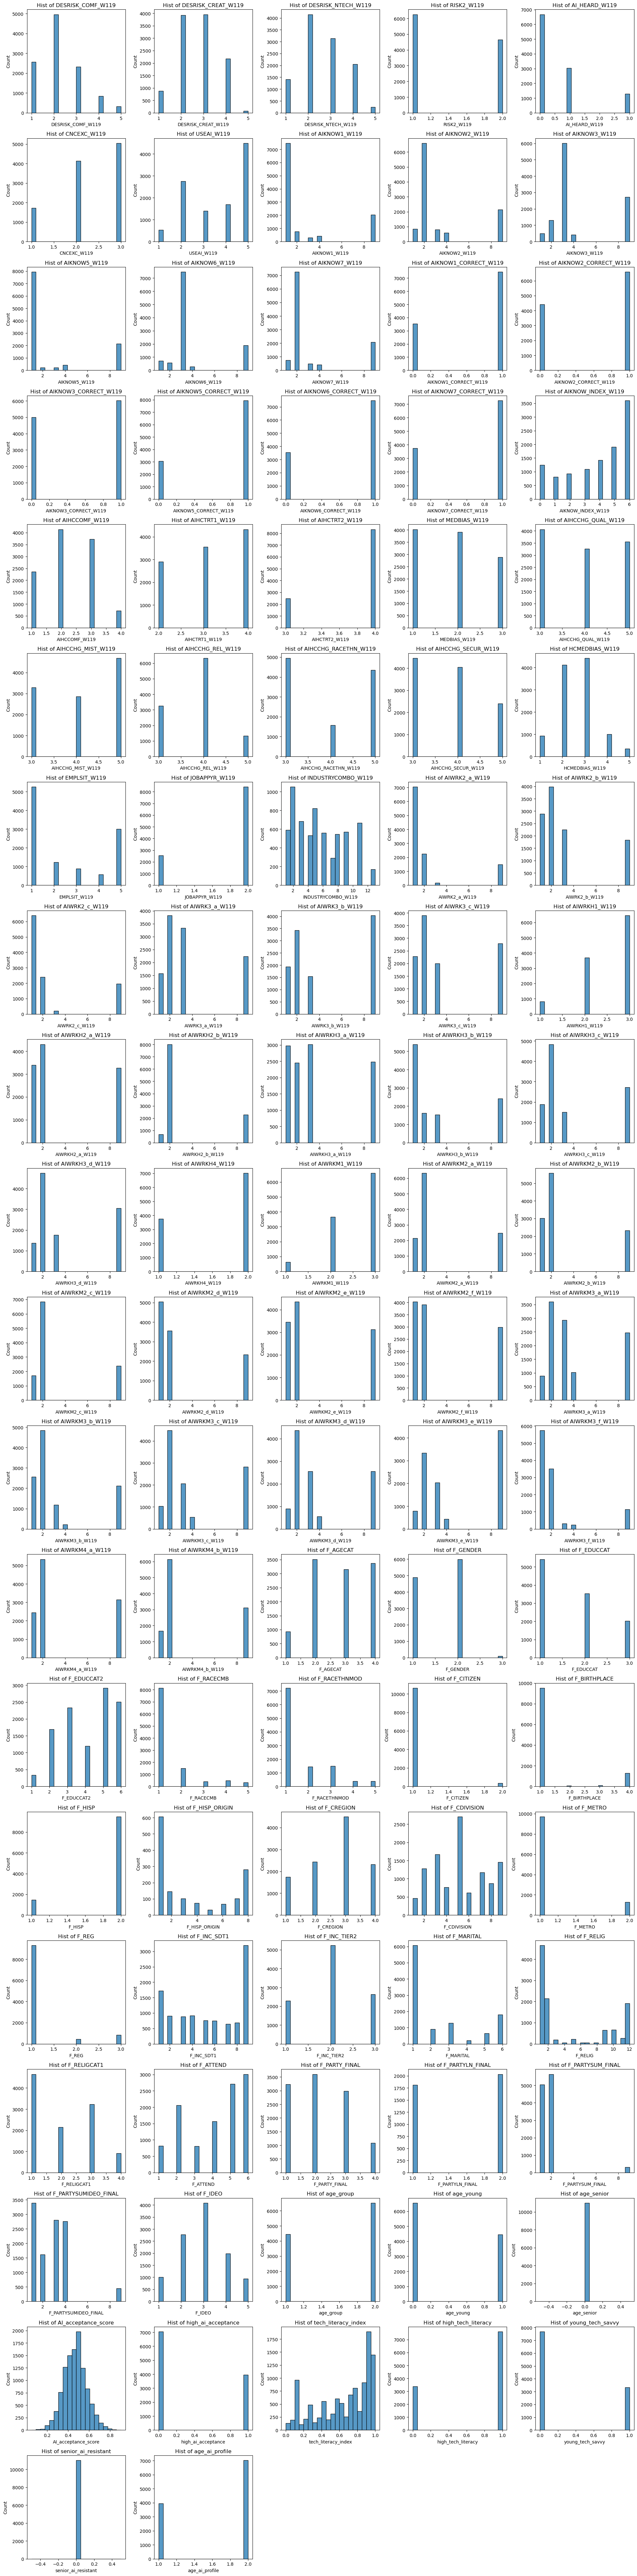

In [65]:


plot_vars(df_features)


In [66]:
df_features.columns

Index(['DESRISK_COMF_W119', 'DESRISK_CREAT_W119', 'DESRISK_NTECH_W119',
       'RISK2_W119', 'AI_HEARD_W119', 'CNCEXC_W119', 'USEAI_W119',
       'AIKNOW1_W119', 'AIKNOW2_W119', 'AIKNOW3_W119', 'AIKNOW5_W119',
       'AIKNOW6_W119', 'AIKNOW7_W119', 'AIKNOW1_CORRECT_W119',
       'AIKNOW2_CORRECT_W119', 'AIKNOW3_CORRECT_W119', 'AIKNOW5_CORRECT_W119',
       'AIKNOW6_CORRECT_W119', 'AIKNOW7_CORRECT_W119', 'AIKNOW_INDEX_W119',
       'AIHCCOMF_W119', 'AIHCTRT1_W119', 'AIHCTRT2_W119', 'MEDBIAS_W119',
       'AIHCCHG_QUAL_W119', 'AIHCCHG_MIST_W119', 'AIHCCHG_REL_W119',
       'AIHCCHG_RACETHN_W119', 'AIHCCHG_SECUR_W119', 'HCMEDBIAS_W119',
       'EMPLSIT_W119', 'JOBAPPYR_W119', 'INDUSTRYCOMBO_W119', 'AIWRK2_a_W119',
       'AIWRK2_b_W119', 'AIWRK2_c_W119', 'AIWRK3_a_W119', 'AIWRK3_b_W119',
       'AIWRK3_c_W119', 'AIWRKH1_W119', 'AIWRKH2_a_W119', 'AIWRKH2_b_W119',
       'AIWRKH3_a_W119', 'AIWRKH3_b_W119', 'AIWRKH3_c_W119', 'AIWRKH3_d_W119',
       'AIWRKH4_W119', 'AIWRKM1_W119', 'AIWRKM2_a

high_tech_literacy
0    0.473693
1    0.464304
Name: AI_acceptance_score, dtype: float64
high_tech_literacy
0    0.468750
1    0.458333
Name: AI_acceptance_score, dtype: float64
high_tech_literacy      
0                   0.25    0.385417
                    0.50    0.468750
                    0.75    0.552083
1                   0.25    0.395833
                    0.50    0.458333
                    0.75    0.531250
Name: AI_acceptance_score, dtype: float64


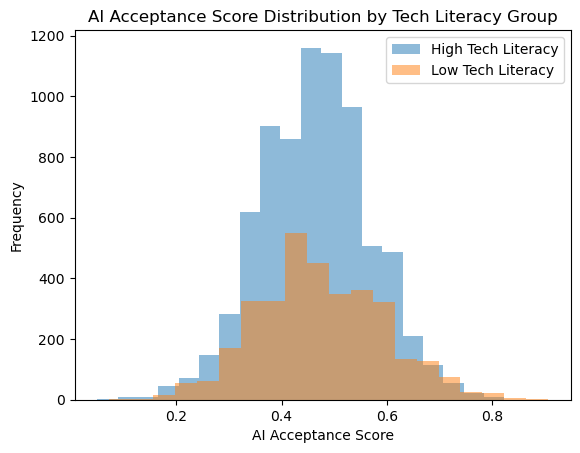

In [82]:
means = df_features.groupby('high_tech_literacy')['AI_acceptance_score'].mean()
medians = df_features.groupby('high_tech_literacy')['AI_acceptance_score'].median()
print(means)
print(medians)
percentiles = df_features.groupby('high_tech_literacy')['AI_acceptance_score'].quantile([0.25, 0.5, 0.75])
print(percentiles)
import matplotlib.pyplot as plt

plt.hist(df_features[df_features['high_tech_literacy']==1]['AI_acceptance_score'], bins=20, alpha=0.5, label='High Tech Literacy')
plt.hist(df_features[df_features['high_tech_literacy']==0]['AI_acceptance_score'], bins=20, alpha=0.5, label='Low Tech Literacy')
plt.legend()
plt.title("AI Acceptance Score Distribution by Tech Literacy Group")
plt.xlabel("AI Acceptance Score")
plt.ylabel("Frequency")
plt.show()



In [ ]:
import pandas as pd
cross = pd.crosstab(df_features['high_tech_literacy'], df_features['high_ai_acceptance'], normalize='index')

print(cross)


-1.3049512274192105
-1.6587597988437712
-0.8338381037315685
0.5844157058622989
high_ai_acceptance         0         1
high_tech_literacy                    
0                   0.613294  0.386706
1                   0.652185  0.347815


# Finding
- Tech literacy is associated with a more centralized, moderate-to-high acceptance of AI, but the overall group difference is not dramatic. The main difference lies in the concentration and peak of the distribution, rather than in the existence of two very different populations. 
- Thile there is a theoretical association between tech literacy and openness to AI, the actual effect in this sample is minimal.
- Therefore, increasing tech literacy alone may not substantially enhance AI acceptance among employees. 


F_AGECAT
1.0    0.484691
2.0    0.467489
3.0    0.466607
4.0    0.462506
Name: AI_acceptance_score, dtype: float64 F_AGECAT
1.0    0.479167
2.0    0.458333
3.0    0.458333
4.0    0.458333
Name: AI_acceptance_score, dtype: float64 F_AGECAT      
1.0       0.25    0.406250
          0.50    0.479167
          0.75    0.562500
2.0       0.25    0.395833
          0.50    0.458333
          0.75    0.541667
3.0       0.25    0.395833
          0.50    0.458333
          0.75    0.541667
4.0       0.25    0.385417
          0.50    0.458333
          0.75    0.531250
Name: AI_acceptance_score, dtype: float64


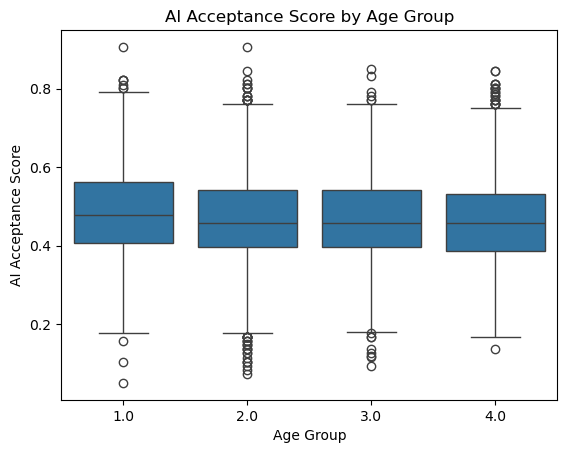

In [89]:
means = df_features.groupby('F_AGECAT')['AI_acceptance_score'].mean()
medians = df_features.groupby('F_AGECAT')['AI_acceptance_score'].median()
percentiles = df_features.groupby('F_AGECAT')['AI_acceptance_score'].quantile([0.25, 0.5, 0.75])
print(means, medians, percentiles)


sns.boxplot(x='F_AGECAT', y='AI_acceptance_score', data=df_features)
plt.title('AI Acceptance Score by Age Group')
plt.xlabel('Age Group')
plt.ylabel('AI Acceptance Score')
plt.show()


F_PARTY_FINAL
1.0    0.461410
2.0    0.470077
3.0    0.469945
4.0    0.468444
Name: AI_acceptance_score, dtype: float64


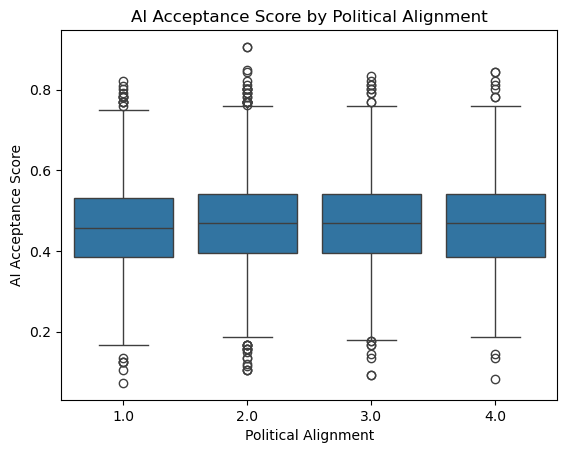

F_PARTY_FINAL
1.0    0.461410
2.0    0.470077
3.0    0.469945
4.0    0.468444
Name: AI_acceptance_score, dtype: float64


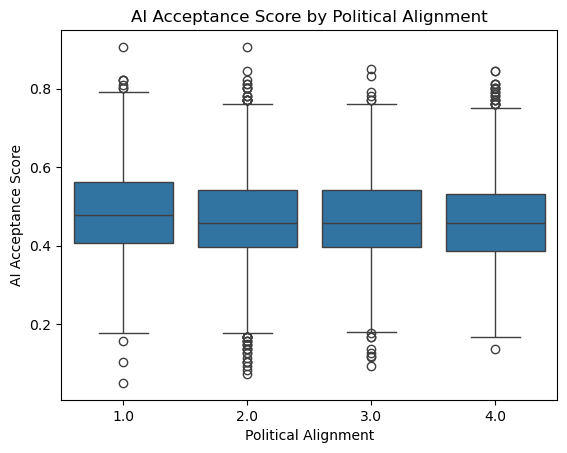

In [96]:
party_means = df_features.groupby('F_PARTY_FINAL')['AI_acceptance_score'].mean()
print(party_means)
sns.boxplot(x='F_PARTY_FINAL', y='AI_acceptance_score', data=df_features)
plt.title('AI Acceptance Score by Political Alignment')
plt.xlabel('Political Alignment')
plt.ylabel('AI Acceptance Score')
plt.show()
party_means = df_features.groupby('F_PARTY_FINAL')['AI_acceptance_score'].mean()
print(party_means)
sns.boxplot(x='F_AGECAT', y='AI_acceptance_score', data=df_features)
plt.title('AI Acceptance Score by Political Alignment')
plt.xlabel('Political Alignment')
plt.ylabel('AI Acceptance Score')
plt.show()


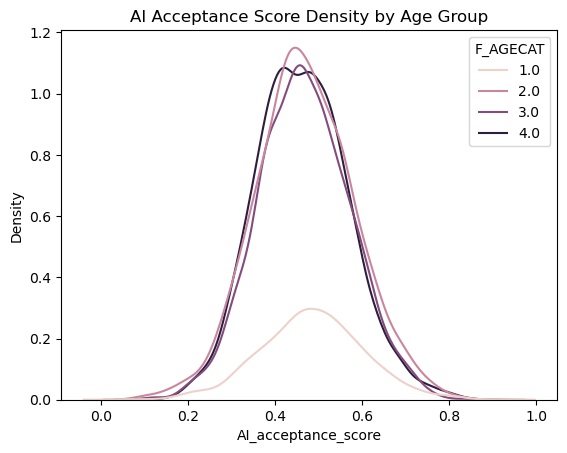

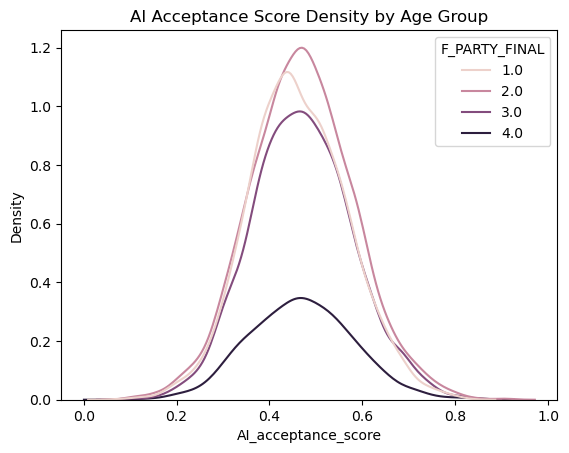

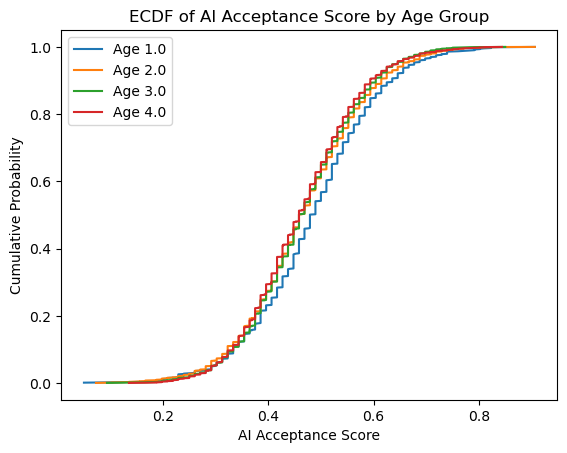

In [ ]:

sns.kdeplot(data=df_features, x='AI_acceptance_score', hue='F_AGECAT')
plt.title('AI Acceptance Score Density by Age Group')
plt.show()

sns.kdeplot(data=df_features, x='AI_acceptance_score', hue='F_PARTY_FINAL')
plt.title('AI Acceptance Score Density by Age Group')
plt.show()
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np




# Finding
- Only the youngest group showed low and scattered characteristics in AI acceptance, while there was almost no difference between the other age groups, indicating that the impact of age was mainly reflected within the young group.
- The distribution of AI acceptance among members of mainstream parties is more concentrated and consistent, while the attitudes of people in the 4.0 political group towards AI are more dispersed and divergent, indicating that political inclination has an important impact on AI acceptance.

high_tech_literacy         0         1
F_AGECAT                              
1.0                 0.501463  0.478148
2.0                 0.483609  0.462273
3.0                 0.471586  0.464569
4.0                 0.463119  0.462106
high_tech_literacy         0         1
F_AGECAT                              
1.0                 0.241379  0.118087
2.0                 0.173458  0.106215
3.0                 0.135224  0.094643
4.0                 0.108271  0.084929


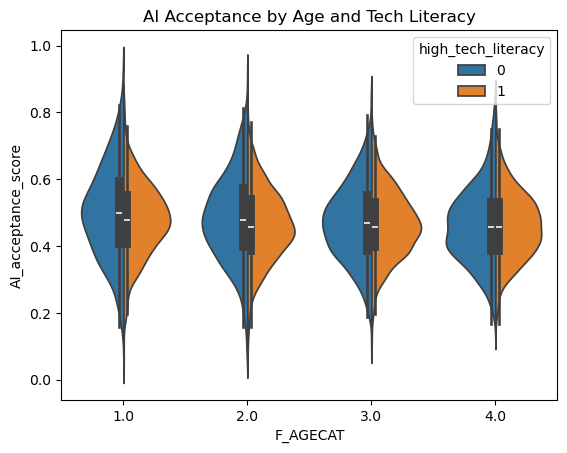

In [107]:

pivot = df_features.pivot_table(
    index='F_AGECAT', 
    columns='high_tech_literacy', 
    values='AI_acceptance_score', 
    aggfunc='mean'
)
print(pivot)

df_features['high_ai_acceptance'] = df_features['AI_acceptance_score'] > 0.6
crosstab = pd.crosstab(
    df_features['F_AGECAT'], df_features['high_tech_literacy'], df_features['high_ai_acceptance'], 
    aggfunc='mean'
)
print(crosstab)

sns.violinplot(
    data=df_features, x='F_AGECAT', y='AI_acceptance_score',
    hue='high_tech_literacy', split=True
)
plt.title('AI Acceptance by Age and Tech Literacy')
plt.show()


The combined group analysis shows that among different age groups, the average AI acceptance of people with low technical literacy (high_tech_literacy=0) is slightly higher than that of people with high technical literacy (high_tech_literacy=1), and this difference does not increase significantly between groups with increasing age. Especially in the older group (F_AGECAT=4), the AI ​​acceptance of people with high and low technical literacy is basically the same.

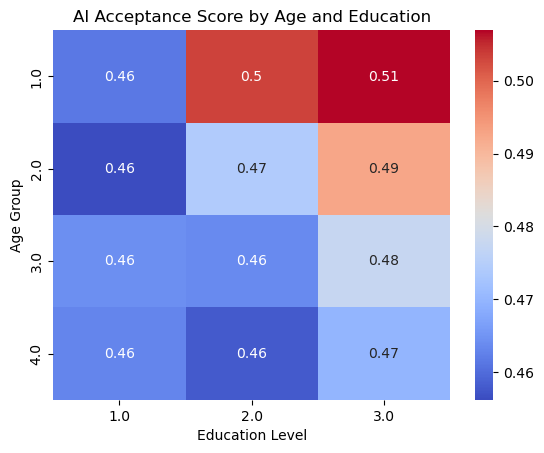

In [108]:
import seaborn as sns
import matplotlib.pyplot as plt

pivot = df_features.pivot_table(
    index='F_AGECAT',
    columns='F_EDUCCAT',
    values='AI_acceptance_score',
    aggfunc='mean'
)
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("AI Acceptance Score by Age and Education")
plt.xlabel("Education Level")
plt.ylabel("Age Group")
plt.show()






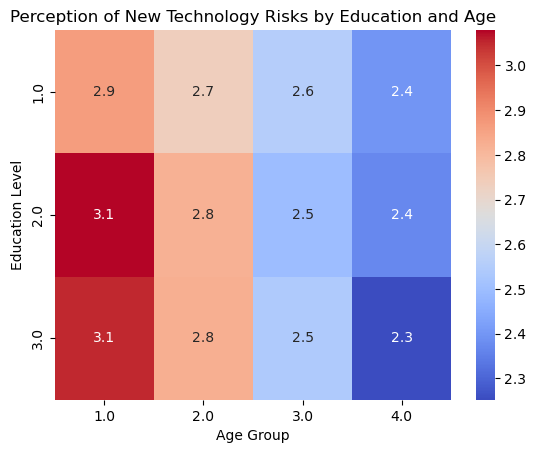

In [120]:



# 1. Descriptive Statistics
key_vars = ['DESRISK_COMF_W119', 'DESRISK_NTECH_W119', 'AIHCCHG_QUAL_W119', 'AIHCCHG_RACETHN_W119', 'MEDBIAS_W119']



# Heatmap: AI risk perception by education and age
pivot = df_features.pivot_table(
    index='F_EDUCCAT', 
    columns='F_AGECAT', 
    values='DESRISK_NTECH_W119', 
    aggfunc='mean'
)
sns.heatmap(pivot, annot=True, cmap='coolwarm')
plt.title("Perception of New Technology Risks by Education and Age")
plt.xlabel("Age Group")
plt.ylabel("Education Level")
plt.show()



- There is a clear declining trend in risk perception with increasing age
- In general, people with higher education have a slightly higher risk perception of new technologies
- This suggests that younger and more highly educated individuals are more attuned to risks associated with new technologies